# Driving force extension method - hands-on tutorial

Reference: 

> J. Zhang, A. F. Chadwick, D. L. Chopp, P. W. Voorhees, “Phase Field Modeling with Large Driving Forces,” npj Computational Materials, 9 (2023) 166. doi: [10.1038/s41524-023-01118-0](https://doi.org/10.1038/s41524-023-01118-0)

# Introduction

Phase field equation typically has the following form
$$
\tau\frac{\partial \phi}{\partial t} = \kappa \nabla^2{\phi} - m g'(\phi) - p'(\phi) F
$$
where $F$ is the driving force. Phase field simulations with a large driving force and a large grid size can be unstable. 


![unstable](img/stability.png) |
-

The driving force extension method introduces a simple modification of the equation
$$
\tau\frac{\partial \phi}{\partial t} = \kappa \nabla^2{\phi} - m g'(\phi) - p'(\phi) \mathcal{P}(F),
$$
where $\mathcal{P}$ projects $F$ to a constant perpendicular to the interface:
$$
\mathcal{P}(F(\vec{x}, t)) = F(\vec{x}_\Gamma, t).
$$
Here, $\vec{x}_\Gamma$ is the closest point on the interface $\Gamma$:
$$
\vec{x}_\Gamma(\vec{x}) = \{\vec{y} : \min_{\vec{y}\in \Gamma} |{\vec{y}-\vec{x}}|\}
$$

![unstable](img/mapping.png) |
-

Let's use the KKS model for demonstration.

# KKS model

Here I use the KKS model<sup>[1]</sup> as an example. Let's first briefly overview the KKS model.

The free energy of the system is
$$
F[\phi, c] = \int{\frac{1}{2}\kappa |{\nabla{\phi}}^2| + m g(\phi) + p(\phi) f^s(c^s)+(1-p(\phi))f^l(c^l) }{\, \mathrm{d} V},
$$
where $\phi$ is the phase field variable and $c$ is concentration.

Two constraints need to be fulfilled. First, the total concentration is interpolated between the phase concentrations
$$
c = p(\phi) c^s + (1-p(\phi)) c^l.
$$
Second, the quasi-local-equilibrium constraint
$$
\tilde{\mu} = \frac{\mathrm{d} f^s}{\mathrm{d} c^s} = \frac{\mathrm{d} f^l}{\mathrm{d} c^l},
$$
where $\tilde{\mu}$ is the diffusion potential. We can solve the phase concentration $c^s$ and $c^l$ from the phase field $\phi$ and the total concentration $c$ from these two constraints.

The evolution equations for the KKS model are
$$
\frac{1}{L} \frac{\partial \phi}{\partial t} = \kappa \nabla^2{\phi} - m g'(\phi) - p'(\phi) \left(f^s -f^l - (c^s-c^l) \tilde{\mu} \right),
$$
$$
\frac{\partial c}{\partial t} = \nabla\cdot{\left(M \nabla{\tilde{\mu}}\right)}.
$$

[1] SG Kim, WT Kim, and T Suzuki. Phase-field model for binary alloys. Physical Review E, 60(6), 7186-7197 (1999).

### Simple case
To make life easier and focus on the stability problem of large driving forces, we make the following assumptions.

First, we assume a parabolic free energy
$$
f^\alpha(c^\alpha) = \frac{1}{2} B (c^\alpha-c^\alpha_0)^2.
$$
Note we assume $A^s=A^l=0$ and $B^s=B^l=B$.

Second, we assume $D=D^s=D^l$.

Third, we assume the interface is at local equilibrium, so the phase field mobility $L$ is
$$
L = \frac{D}{6 a l^2 B \Delta c_0^2},
$$
where $l$ is diffuse interface width, $\Delta c_0 = c_0^l-c_0^s$, $a=5/6$ for third-order interpolation $p(\phi)=\phi^3(3-2\phi)$ and $a=47/60$ for fifth-order interpolation $p(\phi)=\phi^3(6\phi^2-15\phi+10)$.

### Nondimensionalization
We nondimensionalize length by the system size $L_{\text{sys}}$, time by the diffusion timescale $L_{\text{sys}}^2/D$, energy density by $RT/V_m$, concentration by $1/V_m$.

The dimensionless evolution equations are
$$
b \frac{\partial \phi}{\partial t} = \gamma \left(\epsilon^2 \nabla^2{\phi} - \frac{1}{2} g'(\phi)\right) - p'(\phi) F,
$$
$$
B \frac{\partial x}{\partial t} = \nabla^2{\tilde{\mu}},
$$
where $b=6a \epsilon^2 \Delta x_0^2 B$, $\epsilon = l/L_{\text{sys}}$ is the dimensionless interface width, $\gamma = 6 \sigma V_m/(RTl)$ is the dimensionless surface energy, molar fraction $x = V_m c$, and $\Delta x_0 = x_0^l-x_0^s$.

The dimensionless diffusion potential is
$$
\tilde{\mu} = B \left(x - p(\phi) x_0^s - (1-p) x_0^l\right).
$$
The dimensionless driving force is
$$
F = \tilde{\mu} \Delta x_0.
$$
Clearly, $F$ scales with $B$.

### Driving force extension method
The driving force extension method introduces a simple modification of the phase field equation:
$$
b \frac{\partial \phi}{\partial t} = \gamma \left(\epsilon^2 \nabla^2{\phi} - \frac{1}{2} g'(\phi)\right) - p'(u) \color{red}{\mathcal{P}(F)},
$$

# Implementation

For simplicity, let's use a 1D case.

Let's import the needed packages. Here we only need *numpy* and *matplotlib*. If you don't have them installed, use the following command

In [ ]:
!pip install numpy matplotlib

In [1]:
# import needed packages
import numpy as np
import matplotlib.pyplot as plt

Let's define some useful functions. Note that I use cell-based finite difference.

In [2]:
def dg(x): # 0.5 * g'(x)
    return x * (1-x) * (1-2*x)
def laplacian_1d(u, dx): # laplacian of u
    return (u[2:] + u[0:-2] - 2.0 * u[1:-1]) / dx ** 2
def apply_bc(phi, c, xl, xr): # apply boundary conditions
    phi[0]  = phi[1]   # no-flux
    phi[-1] = phi[-2]  # no-flux
    c[0]  = 2 * xl - c[1]   # dirichlet
    c[-1] = 2 * xr - c[-2]  # dirichlet

Let's now implement the driving force extension $\mathcal{P}(f)$. The algorithm has been well-developed in the level-set community and is called the velocity extension<sup>[2]</sup>. The following considers a very simple case: a single interface inside a 1D domain. A general algorithm is needed for more general cases. We will talk about this later.

[2] Adalsteinsson, D. and Sethian, J. The fast construction of extension velocities in level set methods. J. Comput. Phys. 148, 2-22 (1999).

In [3]:
# velocity extension, u is the level-set, u=0 gives the location of the interface
def velext_simple(u, f):
    i = np.where(u[:-1] * u[1:] < 0)[0][0] # find place where u crosses zero
    return (f[i+1]*u[i] - f[i]*u[i+1]) / (u[i]-u[i+1]) # linear interpolation

$u=0$ gives the location of the interface $\Gamma$. You can use $u=\phi-0.5$. 

Let's do a quick test.

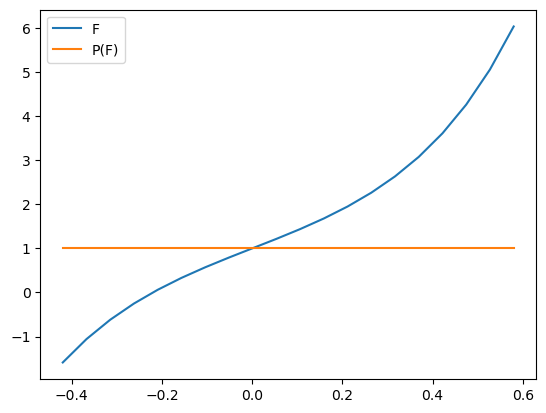

In [4]:
x = np.linspace(0, 1, 20)-0.42 # coordinate
u = x  # interface is at x=0
f = np.sinh(x*4)+1     # driving force
pf=velext_simple(u, f) # projected driving force
plt.plot(u,f, label='F')
plt.plot(u,np.full_like(u,pf), label='P(F)')
plt.legend()

Now, let's implement the KKS model. We set $x_0^s=0.1$ and $x_0^l=0.9$. The molar fraction at the right boundary is fixed to be $x_0=0.5$.

In [5]:
def kks1d(B, dx=0.01, ptype='3rd', dfe=True):
    '''
    B : [] parabolic free energy parameter
    dx : [] grid size
    ptype : type of interpolation function
    dfe : whether we apply for the driving force extension
    ------
    assume D=D^s=D^l, B=B^s=B^l
    '''
    # interpolation function
    if ptype == '3rd':
        pfun  = lambda x : x**2 * (3.0 - 2.0 * x)
        dpfun = lambda x : 6.0 * x * (1-x)
    elif ptype == '5th':
        pfun  = lambda x : x**3 * (6.0 * x**2 - 15.0 * x + 10.0)
        dpfun = lambda x : 30 * x**2 * (1-x)**2

    # geometry
    L = 1.28  # [] size of the whole system
    Li = 0.28 # [] initial location of the interface
    epsilon = 1.5*dx # [] dimensionless interface width

    # parameters
    T = 298.15    # [K] temperature
    R = 8.314     # [J/K mol] gass constant
    Vm = 1.1e-5   # [m^3/mol] molar volume
    Lsys = 100e-6 # [m] system size
    sigma = 0.5   # [J/m^2] surface energy
    gamma = 6*sigma*Vm/(R*T*epsilon*Lsys) # [] dimensionless surface energy
    x0s = 0.1    # [] parabolic free energy parameter
    x0l = 0.9    # [] parabolic free energy parameter
    x0 = 0.5     # [] far field concentration
    a = 5.0 / 6.0 if ptype == '3rd' else 47.0 / 60.0
    one_over_b = 1.0/(6*a*( epsilon * (x0l-x0s) )**2 * B) # [] 1/b
    dt = dx**2/8.0   # [] timestep size

    # initial condition
    nx = int(L/dx) # number of interior grids
    X = np.linspace(-0.5, nx + 0.5, nx + 2) * dx - Li # [] coordinate
    phi = 0.5 * (1.0 - np.tanh(0.5 * X / epsilon))    # [] phase field
    xl = x0l + (X > 0) * X / (L - Li) * (x0 - x0l)    # [] assume an initial linear profile
    p = pfun(phi)
    c = p * x0s + (1-p)*xl # [] concentration
    apply_bc(phi, c, x0s, x0)

    # time loop
    nt = int(0.6/dt)
    for t in range(0, nt):  #
        p = pfun(phi)
        dp = dpfun(phi)[1:-1]
        mu_over_B = c - p*x0s - (1-p)*x0l # diffusion potential
        F = B * mu_over_B * (x0l-x0s)     # driving force

        PF = velext_simple(phi-0.5,F) if dfe else F[1:-1] # driving force extension

        # forward Euler
        dphi = dt * one_over_b * (gamma * (epsilon**2 * laplacian_1d(phi, dx) - dg(phi[1:-1])) - dp*PF)
        dc = dt * laplacian_1d(mu_over_B, dx)

        # update
        phi[1:-1] += dphi
        c[1:-1] += dc
        apply_bc(phi, c, x0s, x0)

    # plotting
    plt.clf()
    plt.plot(X,phi, label='phi')
    plt.plot(X,c, label='c')
    plt.legend()

Let's try it!

In [ ]:
kks1d(B=0.001, dx=0.01, ptype='3rd', dfe=False)

In [ ]:
kks1d(B=0.01, dx=0.01, ptype='3rd', dfe=False)

In [ ]:
kks1d(B=0.01, dx=0.01, ptype='5th', dfe=False)

In [ ]:
kks1d(B=0.1, dx=0.01, ptype='5th', dfe=False)

In [ ]:
kks1d(B=0.1, dx=0.005, ptype='5th', dfe=False)

In [ ]:
kks1d(B=1.0, dx=0.005, ptype='5th', dfe=False)

You will get something like

![result](img/kks_stability.png) |
-

For the case of the original model, the 5-th order interpolation is more stable than the 3-rd order interpolation. However, they both have an upper bound on the magnitude of the driving force.

In [ ]:
kks1d(B=1.0, dx=0.005, ptype='3rd', dfe=True)

The driving force extension method does not have this upper bound.

## Velocity extension for general cases

For more general cases, we need more complex velocity extension algorithms. See Ref.[3] for a review. Following is a modified version of the Fast Sweep Method/Fast Iterative Method for the 1D case.

[3] G&oacute;mez et al, Fast methods for Eikonal equations: an experimental survey, IEEE Access (2019)

In [6]:
def velext_fim(u, f): # velocity extension general 1D case (fast iterative method)
    nx = u.shape[0]
    d = np.full_like(u, np.inf)       # distance function
    s = np.full_like(u, 2, dtype=int) # 1 - distant, 0 - tentaive, -1 - initialize, -2 - converged
    w = np.empty_like(f) # extended driving force
    id = np.where(u[:-1] * u[1:] < 0)[0]
    assert id.size, "no interface!"
    for i in id:
        s[i:i+2] = -1
        t_ = u[i] / (u[i]-u[i+1]) # linear interpolation
        d[i] = np.abs(t_)
        d[i+1] = np.abs(1-t_)
        w[i] = (1-t_)*f[i]+t_*f[i+1] # extended driving force
        w[i+1] = w[i]
    while np.any(s>-1): # loop until everything is converged
        for i in range(0, nx-1, 1): # sweep ->
            if s[i] < 1 and s[i+1] > -1:
                d_ = d[i]+1
                r_ = d[i+1] - d_ # difference
                if r_ >= 0:
                    d[i+1] = d_ # update
                    if r_ == 0 and s[i]<0:
                        s[i+1] = -2 # converged
                        w[i+1] = w[i]
                    else:
                        s[i+1] = 0 # active
        for i in range(nx-1, 0, -1): # sweep <-
            if s[i] < 1 and s[i-1] > -1:
                d_ = d[i]+1
                r_ = d[i-1] - d_ # difference
                if r_ >= 0:
                    d[i-1] = d_ # update
                    if r_ == 0 and s[i]<0:
                        s[i-1] = -2 # converged
                        w[i-1] = w[i]
                    else:
                        s[i-1] = 0 # active
    return w[1:-1] # without ghost layer

Let's test it.

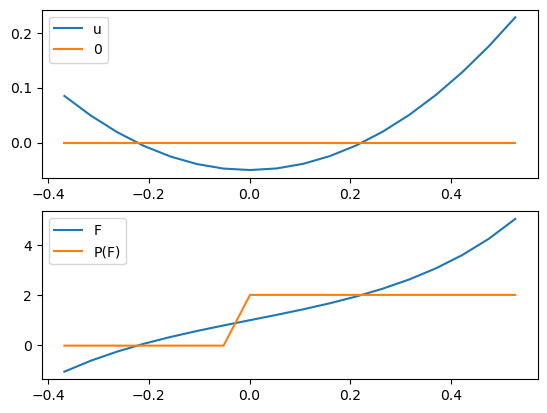

In [7]:
x = np.linspace(0, 1, 20)-0.42
u = x**2-0.05
f = np.sinh(x*4)+1
pf=velext_fim(u, f)
plt.subplot(211)
plt.plot(x[1:-1],u[1:-1], label='u')
plt.plot(x[1:-1],0*u[1:-1], label='0')
plt.legend()
plt.subplot(212)
plt.plot(x[1:-1],f[1:-1], label='F')
plt.plot(x[1:-1],pf, label='P(F)')
plt.legend()

# Summary

The driving force extension method can solve the stability problem with a large driving force. It is simple because you can easily combine it with your existing phase field code.

You can find more details in our paper. For questions, comments, suggestions, or bug reports, email me at [jzhang\@northwestern.edu](mailto:jzhang@northwestern.edu) or visit [github](https://github.com/jijn/dfe_tutorial).